**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
sys.path.append('../../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train,  prep_coco_dataset
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# def get_ax(rows=1, cols=1, size=16):
#     """Return a Matplotlib Axes array to be used in
#     all visualizations in the notebook. Provide a
#     central point to control graph sizes.
    
#     Adjust the size attribute to control how big to render images
#     """
#     _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
#     return ax


## Configurations

DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
# fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
 
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'
fcn_config.display()

## Build FCN Model

with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN8', config=fcn_config)

fcn_model.keras_model.summary()

Using TensorFlow backend.


/home/kbardool/models/train_fcn_coco

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SI

## Set weight files

In [3]:
DIR_WEIGHTS =  'F:/models/train_fcn8_coco_adam/fcn20181109T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# DIR_WEIGHTS =  '/home/kbardool/models/train_fcn8_coco_adam/fcn20181109T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
files   = ['fcn_0006.h5','fcn_0133.h5','fcn_0252.h5','fcn_0330.h5','fcn_0417.h5','fcn_0582.h5','fcn_0787.h5','fcn_0839.h5']

In [ ]:
for i in files:
    filename = files[0]
    weights_path = os.path.join(DIR_WEIGHTS  , filename)
    fcn_model.load_model_weights(weights_path)   
    a = visualize.display_weight_histograms(fcn_model, filename = filename)
    weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
    a.savefig(weights_histogram)

## Load Weights - 1

In [4]:
filename = files[0]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0006.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0006.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0006.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [5]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0740160346,+0.0894907564,+0.0391959250
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0150693040,+0.0191380158,+0.0072059999
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0729580820,+0.0838534981,+0.0416811109
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0103867957,+0.0249452107,+0.0061228499
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0605502389,+0.0648240969,+0.0340550952
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0130844945,+0.0181616936,+0.0060310089
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0517127365,+0.0558981821,+0.0294358302
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0128617696,+0.0184782930,+0.0063410280
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0425025113,+0.0461398177,+0.0240528453
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0154929860,+0.0264911689,+0.0061810520


### Histograms of Weights - 1st weight file

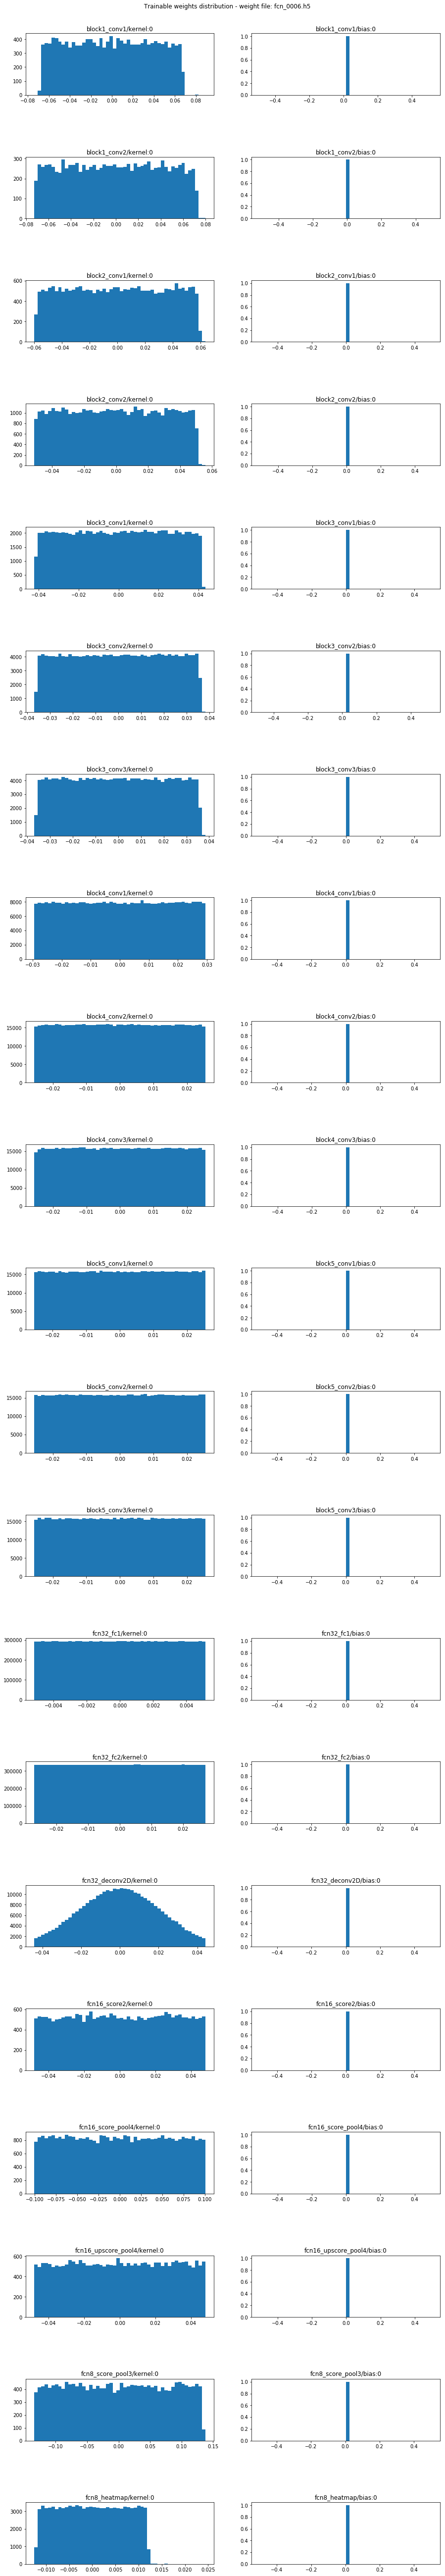

In [6]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 2

In [7]:
filename = files[1]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0133.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0133.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0133.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [8]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1358045042,+0.1228978857,+0.0395342708
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0505952723,+0.0762218907,+0.0322357193
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1267506033,+0.1169268861,+0.0420729145
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0509306788,+0.0606773533,+0.0246974342
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1209678128,+0.0973992199,+0.0345133059
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0543998443,+0.0460368656,+0.0206285436
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1023668274,+0.0934028998,+0.0298189502
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0557529703,+0.0544864126,+0.0195496678
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0972905084,+0.0898301974,+0.0244856216
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0565229170,+0.0751644671,+0.0237720050


### Histograms of Weights - 2nd weights file

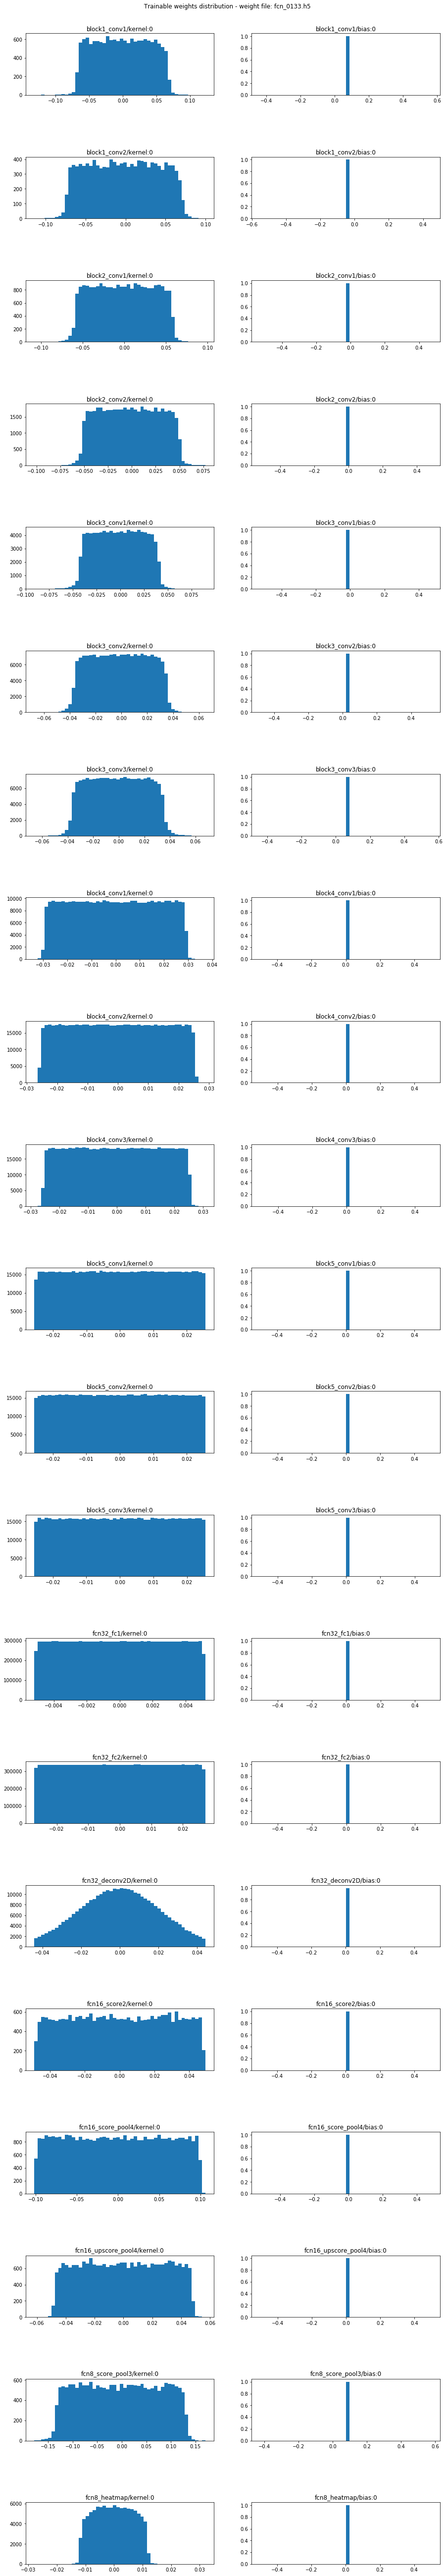

In [9]:
a = visualize.display_weight_histograms(fcn_model, filename = files[1])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[1]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [10]:
weights_path = os.path.join(DIR_WEIGHTS  , files[2])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0252.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0252.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0252.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0252.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

In [11]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1743561774,+0.1374304593,+0.0398756601
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0740311444,+0.0899505094,+0.0426826589
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1376691014,+0.1317952871,+0.0423555560
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0603962168,+0.0691140741,+0.0267507602
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1456510127,+0.1313276142,+0.0349870361
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0939855874,+0.0620271675,+0.0286796875
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1234843731,+0.1122719869,+0.0303004924
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0624256358,+0.0627643541,+0.0244737081
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1222927496,+0.1252893955,+0.0249414835
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0953963622,+0.0793011039,+0.0270385370


### Histograms of Weights - 3rd weight file

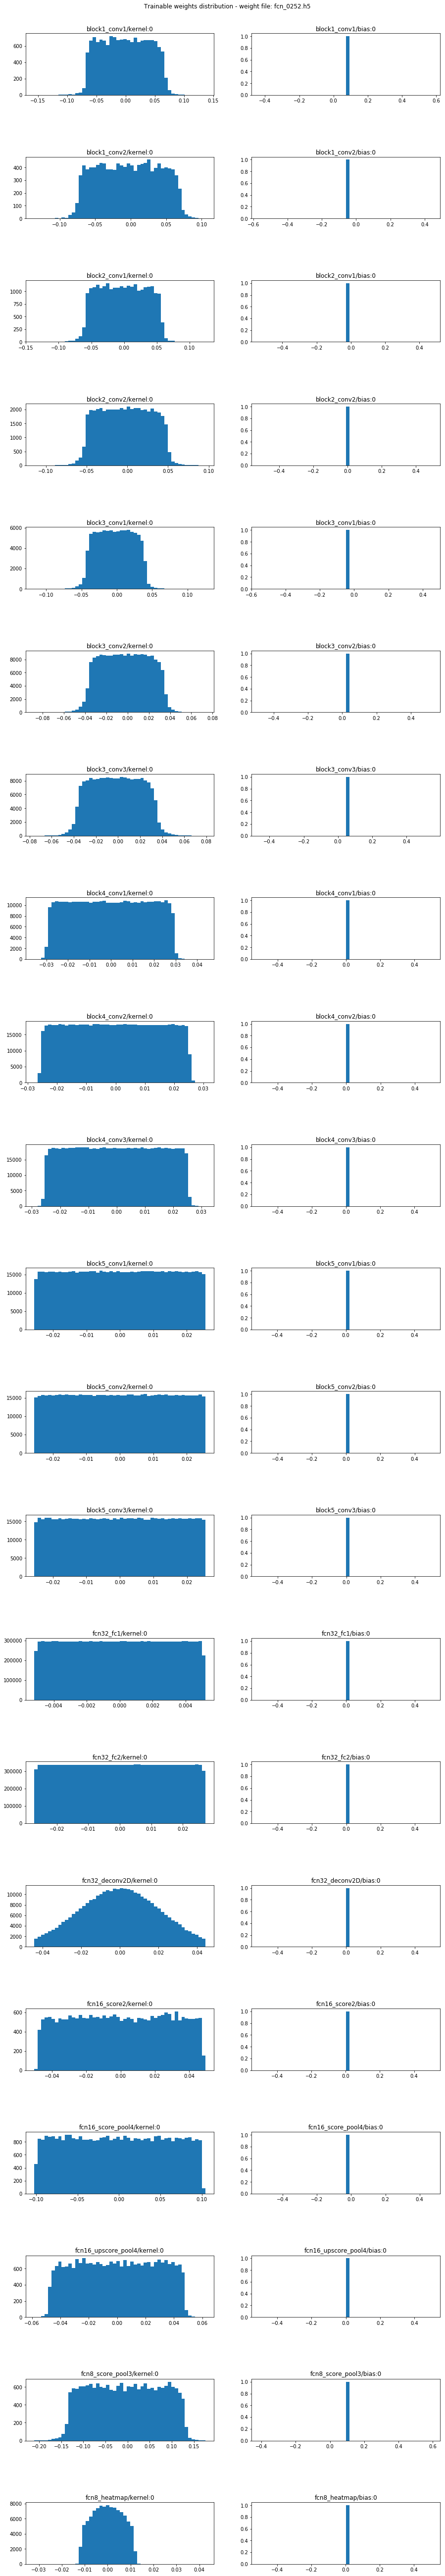

In [12]:
a = visualize.display_weight_histograms(fcn_model, filename = files[2])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [13]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0330.h5
-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0330.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0330.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0330.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [14]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1756303161,+0.1414951086,+0.0398719907
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0716359019,+0.0990749523,+0.0439660251
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1375334263,+0.1321677119,+0.0423619710
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0603502728,+0.0788883865,+0.0281707868
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1465287060,+0.1350659430,+0.0349960178
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0945149064,+0.0614703149,+0.0283238161
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1243643314,+0.1107485294,+0.0303048231
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0624775402,+0.0684981048,+0.0261927452
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1220613495,+0.1225854680,+0.0249442589
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.1033392847,+0.0828413442,+0.0279586501


### Histograms of Weights

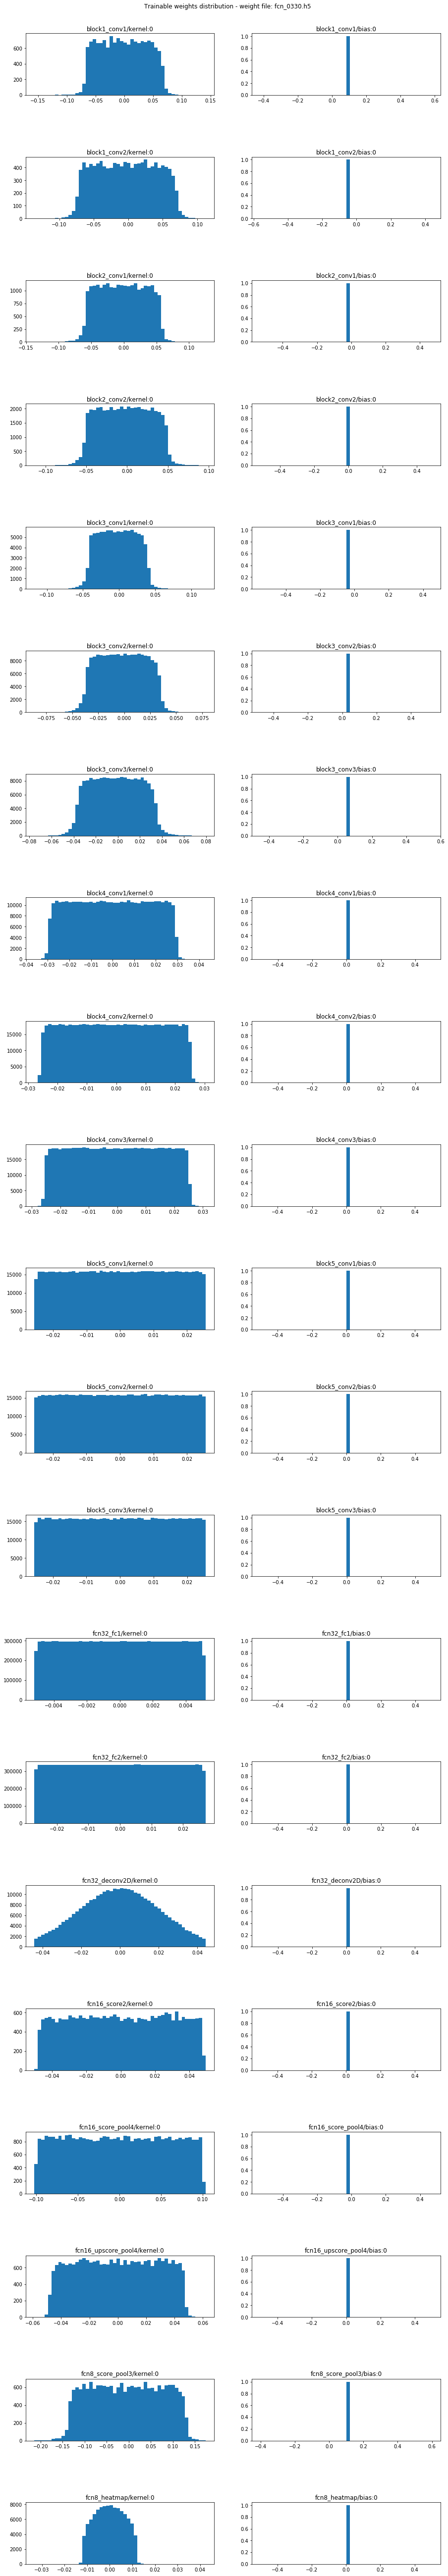

In [15]:
a = visualize.display_weight_histograms(fcn_model, filename = files[3])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [16]:
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0417.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0417.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0417.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [17]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1986105740,+0.1590201706,+0.0403599106
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0785444826,+0.0953322798,+0.0475403033
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1496180892,+0.1428262144,+0.0427925773
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0665664971,+0.0715680793,+0.0316007920
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1608013064,+0.1454842091,+0.0353956632
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.1174157932,+0.0765260980,+0.0350970179
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1426339746,+0.1281557977,+0.0306974184
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0859866589,+0.0696501508,+0.0285583306
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1457184553,+0.1468106806,+0.0253282096
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.1353122592,+0.0798464641,+0.0318124928


### Histograms of Weights - 5th weight file

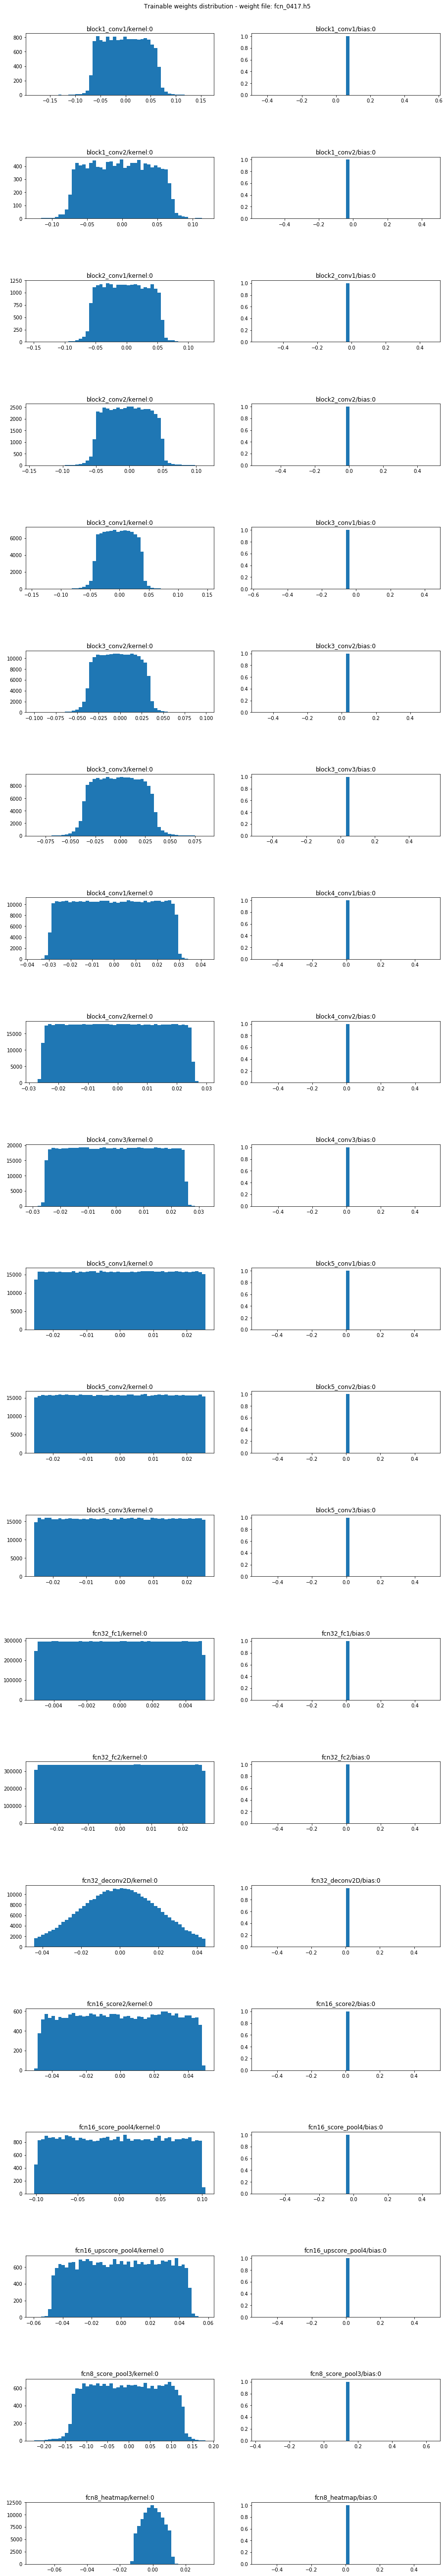

In [18]:
a = visualize.display_weight_histograms(fcn_model, filename = files[4])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [19]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0582.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0582.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0582.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 6th weight file

In [20]:
# Show stats of all trainable weights    
_=visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.1993774176,+0.1575855911,+0.0403530970
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0810230151,+0.0941449553,+0.0477089472
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1499080807,+0.1406651139,+0.0427812040
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0667669103,+0.0706360415,+0.0310774539
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1611679643,+0.1458739042,+0.0353881717
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.1174157932,+0.0724205077,+0.0347439088
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1427337378,+0.1265394390,+0.0306938663
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0848036259,+0.0709290355,+0.0283255391
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1456374228,+0.1436957866,+0.0253259297
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.1345672905,+0.0795503706,+0.0318621770


### Histograms of Weights - 6th weight file

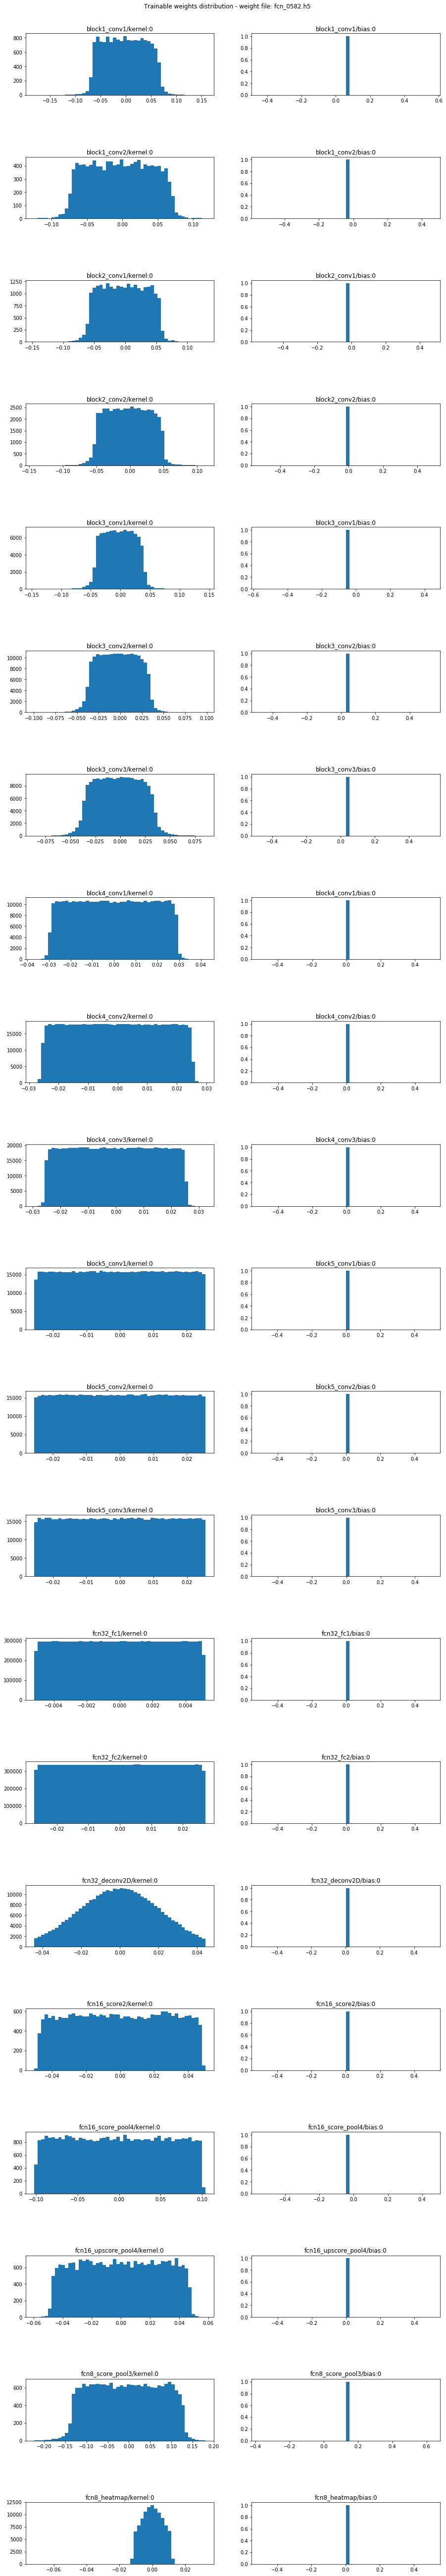

In [21]:
a = visualize.display_weight_histograms(fcn_model, filename = files[5])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [22]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0787.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0787.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0787.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 7th weight file

In [23]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.2008652836,+0.1570441574,+0.0403481610
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0814608783,+0.0936536044,+0.0474460796
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1496910304,+0.1390561759,+0.0427779444
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0652652755,+0.0754966810,+0.0309695061
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1618887931,+0.1459822804,+0.0353908874
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.1174157932,+0.0710785687,+0.0347835831
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1423416883,+0.1264700145,+0.0306990668
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0837736428,+0.0716615915,+0.0290589184
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1475307494,+0.1439572126,+0.0253319070
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.1345786601,+0.0744099692,+0.0317024030


### Histograms of Weights - 7th weight file

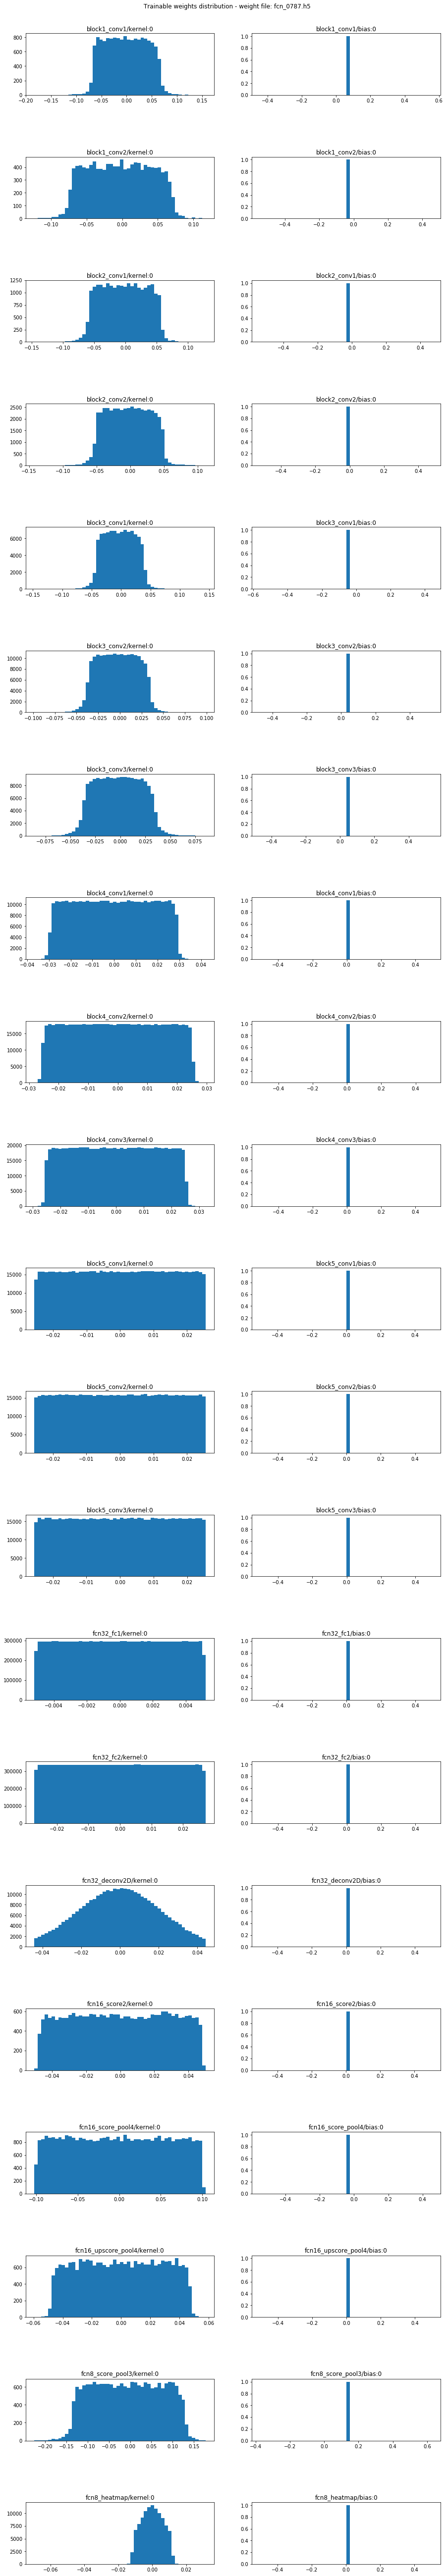

In [24]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)

## Load Weights - 8th weight file

In [25]:
filename = files[7]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0839.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0839.h5
layers type:  <class 'list'> length:  34
    Weights file loaded: F:/models/train_fcn8_coco_adam/fcn20181109T0000\fcn_0839.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 8th weight file

In [26]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.2029585689,+0.1557941139,+0.0403490365
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0794931799,+0.0936456919,+0.0474985503
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.1505462825,+0.1405237317,+0.0427871533
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0630548820,+0.0807920247,+0.0315164030
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.1619890332,+0.1488416195,+0.0353976861
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.1174157932,+0.0711830854,+0.0353582241
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.1428937763,+0.1267995089,+0.0307055861
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0810931027,+0.0733706877,+0.0288723763
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.1474007368,+0.1433269829,+0.0253366269
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.1352434605,+0.0739344880,+0.0321050622


### Histograms of Weights - 8th weight file

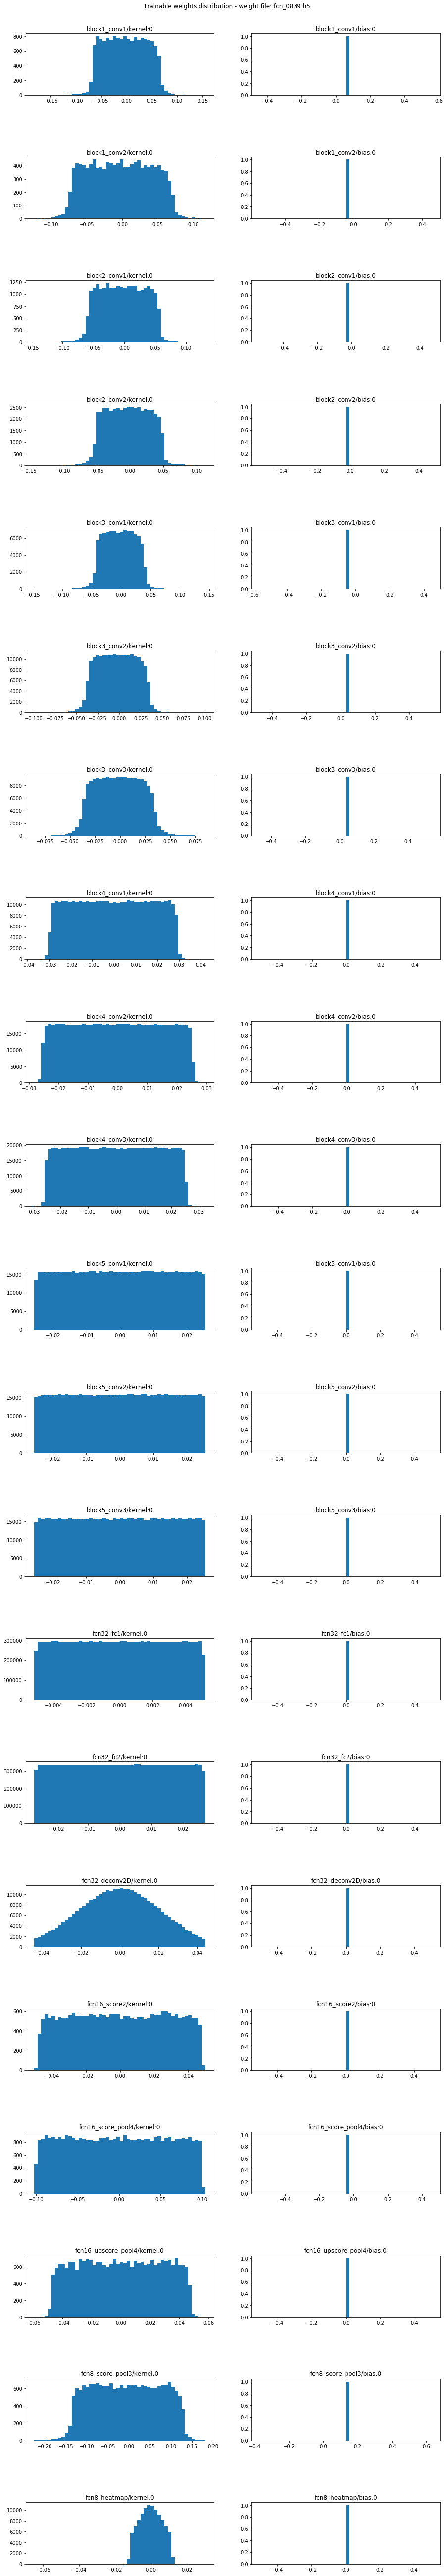

In [27]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 9th weight file

In [31]:
filename = files[8]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0051.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0051.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0051.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 9th weight file

In [33]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042993,+0.0678054392,+0.0391615890
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0001836142,+0.0001406675,+0.0000577579
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721677393,+0.0721659958,+0.0415693894
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0002564314,+0.0000966926,+0.0000792626
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589281619,+0.0589237697,+0.0339858271
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0003208704,+0.0002524866,+0.0001026464
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510350280,+0.0510308929,+0.0295056943
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0004453983,+0.0002461205,+0.0001259885
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416728295,+0.0416672044,+0.0240640044
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0004364855,+0.0003213162,+0.0001194461


### Histograms of Weights - 9th weight file

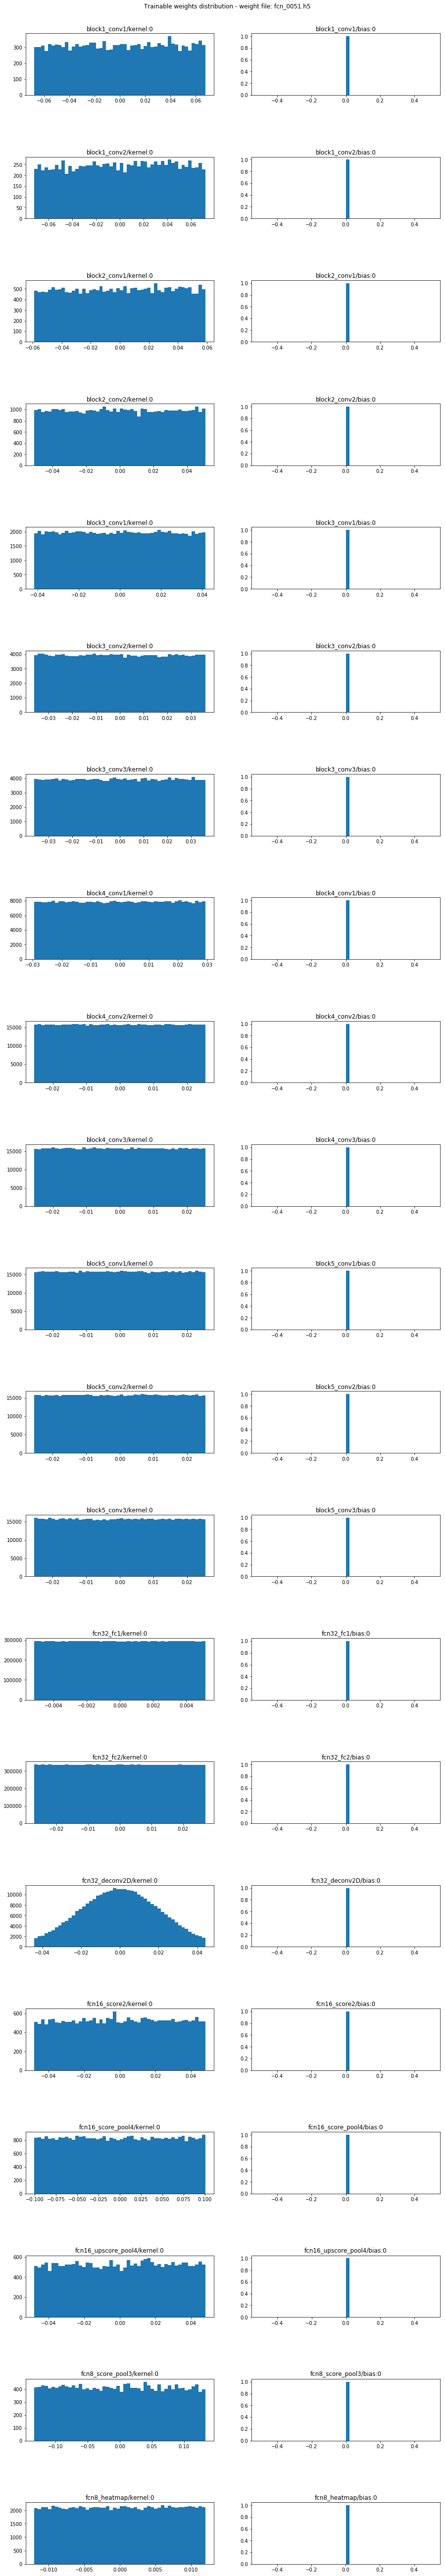

In [34]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 10th weight file

In [35]:
filename = files[9]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0073.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0073.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0073.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 10th weight file

In [36]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042769,+0.0678054318,+0.0391615406
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0002523395,+0.0001861676,+0.0000822630
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721679926,+0.0721660033,+0.0415693298
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0003719760,+0.0001423818,+0.0001111777
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589296073,+0.0589236207,+0.0339857936
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0004520004,+0.0003455982,+0.0001430740
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510385446,+0.0510308631,+0.0295056719
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0006098283,+0.0003742259,+0.0001750494
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416772589,+0.0416682176,+0.0240639914
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0006054761,+0.0004463716,+0.0001651182


### Histograms of Weights - 10th weight file

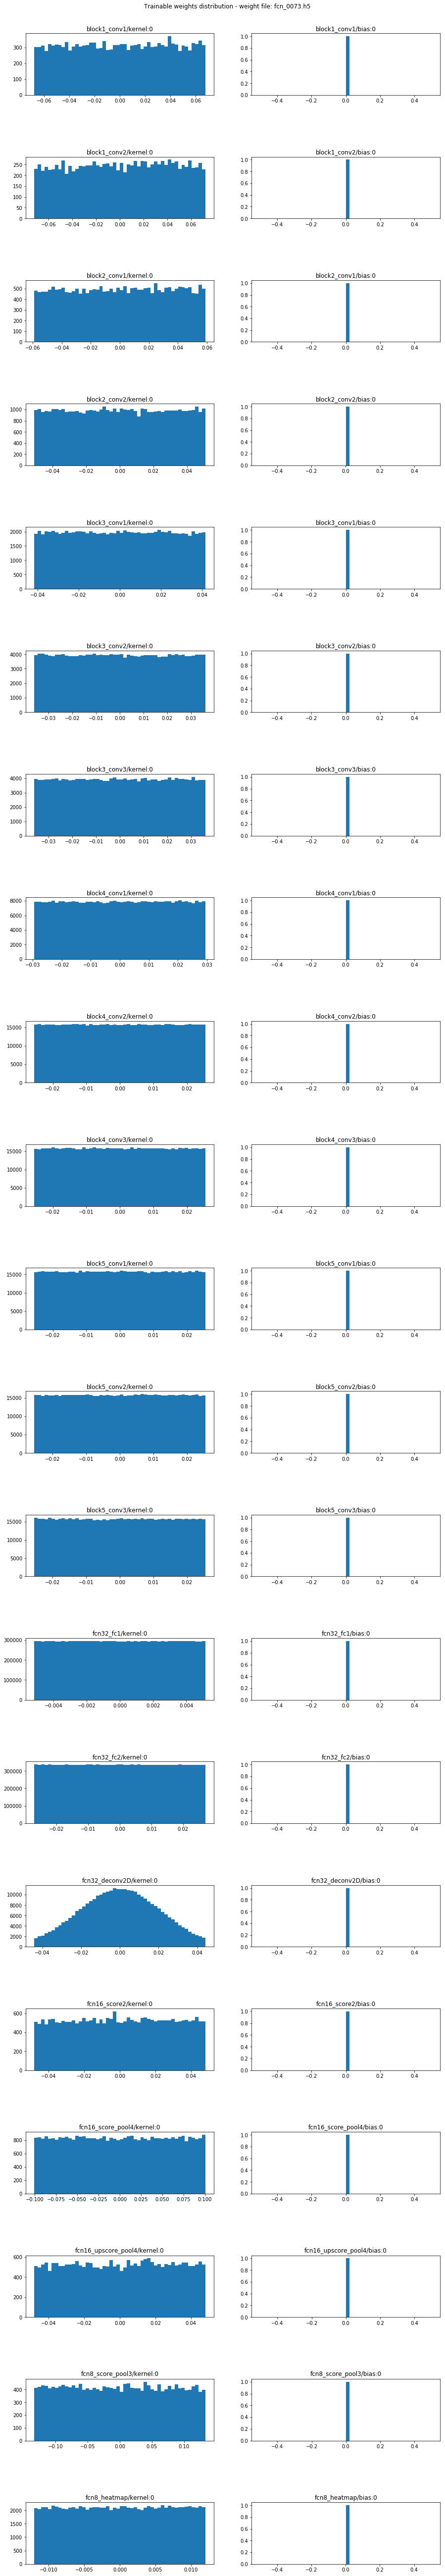

In [37]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 11th weight file

In [38]:
filename = files[10]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0081.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0081.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0081.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 11th weight file

In [39]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042769,+0.0678054318,+0.0391615257
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0002745829,+0.0001991909,+0.0000900953
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721680075,+0.0721660033,+0.0415693112
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0004131656,+0.0001532655,+0.0001221600
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589301772,+0.0589236282,+0.0339857750
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0004959522,+0.0003760874,+0.0001564253
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510395393,+0.0510307774,+0.0295056645
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0006664819,+0.0004180047,+0.0001912711
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416786037,+0.0416687764,+0.0240639858
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0006553022,+0.0004877669,+0.0001796684


### Histograms of Weights - 11th weight file

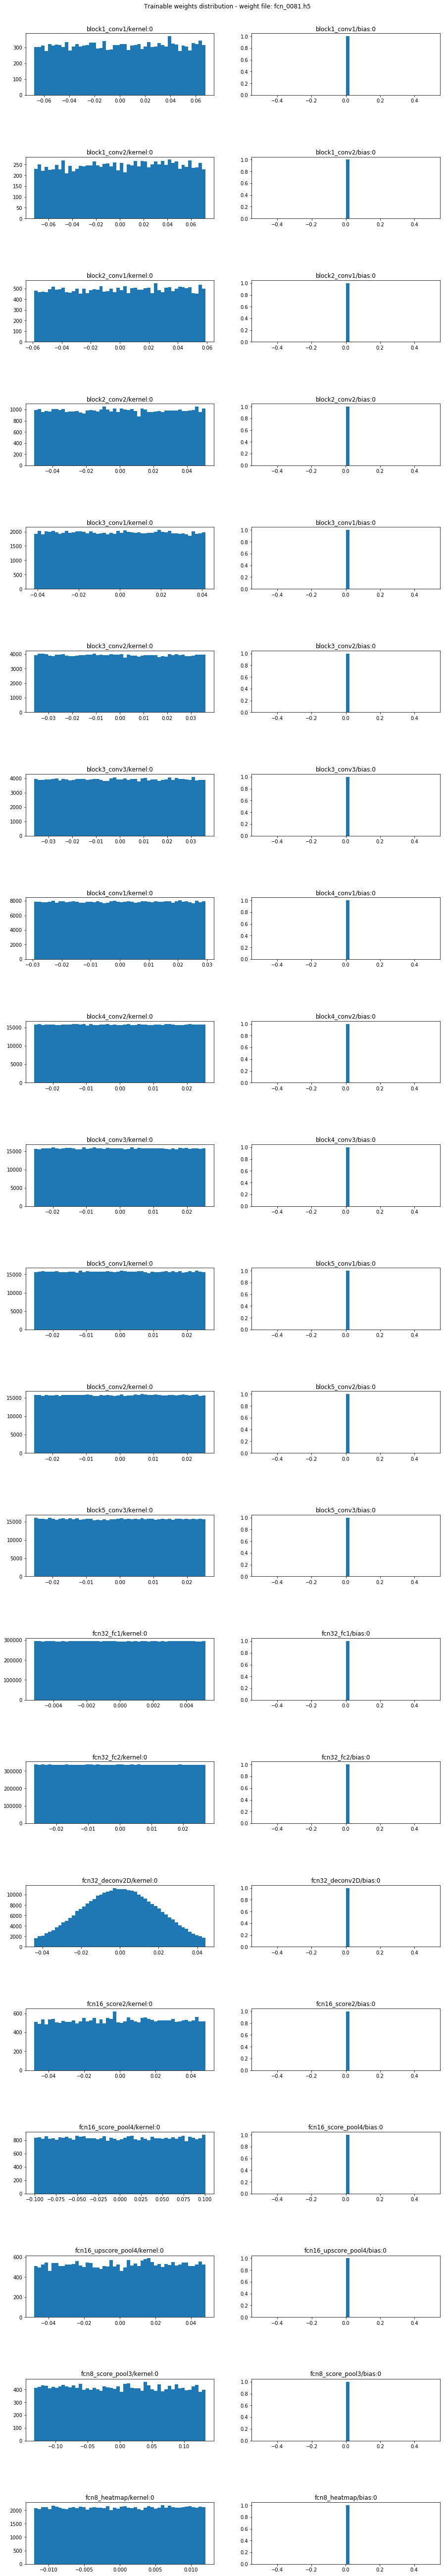

In [40]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)